In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

### **Device agnostic to use gpu**

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### **Data**
* defining transforms
* loading dataset into dataloaders
* inspecting the data

**The transforms.Normalize((0.5,), (0.5,)) operation does two things:**

* It subtracts the mean of 0.5 from each pixel value.

* It divides the result by the standard deviation of 0.5.

* This transforms the pixel values from the range of [0, 1] to [-1, 1].

**Why 0.5?**
* The transforms.ToTensor() step scales the original pixel values (0-255) to the [0.0, 1.0] range. 
* By choosing a mean of 0.5, we center the data around zero (0.5 - 0.5 = 0). 
* By choosing a standard deviation of 0.5, we squash the [0, 1] range into a [-1, 1] range ((1 - 0.5) / 0.5 = 1 and (0 - 0.5) / 0.5 = -1). 
* These values aren't universally required, but they are a very common choice for simple image normalization and work well for MNIST.

In [ ]:
#define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [32]:
batch_size = 64
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [33]:
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

### Inspecting shapes:


In [38]:
images, labels = next(iter(train_loader)) ### grab the first batch from dataloader and so osn...

print(f"Shape of one batch of images: {images.shape}")
print(f"Shape of one batch of labels: {labels.shape}")

# Now let's look at the shape of a single image
print(f"Shape of a single image: {images[0].shape}")

Shape of one batch of images: torch.Size([64, 1, 28, 28])
Shape of one batch of labels: torch.Size([64])
Shape of a single image: torch.Size([1, 28, 28])


### Visualization

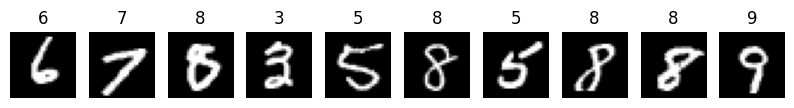

In [42]:
import matplotlib.pyplot as plt

# Get one batch
images, labels = next(iter(train_loader))

# Unnormalize: [0,1] from [-1,1]
images = images * 0.5 + 0.5  

# Create subplots
fig, axes = plt.subplots(1, 10, figsize=(10, 4))

for i in range(10):
    img = images[i].squeeze().numpy()   # [1,28,28] -> [28,28]
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(labels[i].item())
    axes[i].axis("off")

plt.show()


In [44]:
class MNISTCLASSIFICATION(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # PyTorch's nn.Linear handles weight and bias initialization for us.
        self.fc1 = nn.Linear(input_size, hidden_size)   # first layer
        self.relu = nn.ReLU() # activation fn to introduce non linearity
        self.fc2 = nn.Linear(hidden_size, output_size)  # output layer
    
    def forward(self, x):
        # We need to flatten the input images from their shape of [batch_size, 1, 28, 28] 
        # to a shape of [batch_size, 784] so they can be processed by the linear layer.
        
        # The flatten() method is used here to achieve this. It flattens all dimensions
        # starting from `start_dim` (which is 1, corresponding to the channel dimension).
        # This converts the [1, 28, 28] part of the tensor into a single dimension of 784.
        x = x.flatten(start_dim=1)

        # Alternatively, you could use the view() method, which requires you to
        # explicitly state the new dimensions. The -1 is a special placeholder
        # that tells PyTorch to automatically figure out the batch size.
        # x = x.view(-1, 28 * 28)
        
        # Pass the flattened data through the layers.
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [45]:
model = MNISTCLASSIFICATION(input_size=784, hidden_size=128,output_size=10)

In [46]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.0285, -0.0232, -0.0070,  ...,  0.0306, -0.0103, -0.0163],
                      [-0.0157,  0.0030,  0.0111,  ..., -0.0077,  0.0101, -0.0174],
                      [ 0.0099,  0.0085, -0.0068,  ...,  0.0148, -0.0075,  0.0308],
                      ...,
                      [ 0.0100, -0.0163, -0.0166,  ...,  0.0023,  0.0245, -0.0059],
                      [-0.0030,  0.0275,  0.0151,  ..., -0.0103,  0.0168, -0.0236],
                      [ 0.0310,  0.0038,  0.0049,  ...,  0.0225,  0.0354, -0.0275]])),
             ('fc1.bias',
              tensor([-6.4277e-03, -3.4262e-02, -1.1843e-02, -2.8373e-02,  2.8005e-02,
                      -4.0876e-03,  2.8891e-02, -7.8520e-03,  1.3585e-02,  2.1573e-02,
                      -3.2973e-02,  3.4032e-02, -1.3503e-02, -3.1920e-02,  2.3605e-02,
                      -9.8153e-03, -3.1379e-02, -1.6403e-03,  6.9767e-03, -3.3418e-02,
                      -2.3790e-02, -7.6082e-03,  3.0291e-03, -8.

### Loss fn and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = optim.SGD(params=model.parameters(),lr=learning_rate)

### Training the  model

In [50]:
epochs = 50
model.to(device)

for epoch in tqdm(range(epochs)):
    # 1. model set to train mode (track gradients)
    model.train()
    
    for batch_idx, (X, y) in enumerate(train_loader):
        # Send data to device
        X, y = X.to(device), y.to(device)

        # 2. forward pass
        y_pred = model(X.view(X.size(0), -1))  # flatten for Linear

        # 3. calc the loss
        loss = loss_fn(y_pred, y)

        # 4. backward pass
        optimizer.zero_grad()
        loss.backward()

        # 5. optimizer step (update params)   
        optimizer.step()

    # Log every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{epochs} | Loss: {loss.item():.4f}")


 20%|██        | 10/50 [01:39<06:36,  9.92s/it]

Epoch: 10/50 | Loss: 0.2088


 40%|████      | 20/50 [03:20<05:04, 10.15s/it]

Epoch: 20/50 | Loss: 0.0881


 60%|██████    | 30/50 [05:04<03:28, 10.43s/it]

Epoch: 30/50 | Loss: 0.2265


 80%|████████  | 40/50 [06:44<01:40, 10.02s/it]

Epoch: 40/50 | Loss: 0.0327


100%|██████████| 50/50 [08:24<00:00, 10.09s/it]

Epoch: 50/50 | Loss: 0.0297


### inference 

In [51]:
model.eval()  # set to evaluation mode

with torch.inference_mode():  # no gradients
    correct = 0
    total = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # forward pass
        outputs = model(images.flatten(start_dim=1))

        # get predicted class (index of max logit)
        predicted = outputs.argmax(dim=1)

        # update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"\nTest Accuracy: {accuracy:.2f}%")



Test Accuracy: 97.52%


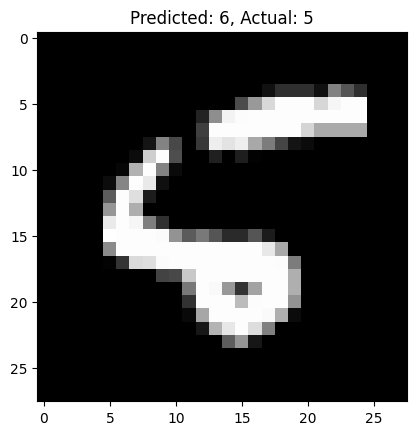

In [54]:
model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images.view(images.size(0), -1))
        _, predicted = torch.max(outputs.data, 1)

        # Find the indices of incorrect predictions
        incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]
        
        if len(incorrect_indices) > 0:
            # Let's plot the first incorrect prediction we find
            first_incorrect_idx = incorrect_indices[0]
            
            # Reverse normalization for visualization
            img_tensor = images[first_incorrect_idx].cpu() * 0.5 + 0.5
            img_np = img_tensor.squeeze().numpy()

            plt.imshow(img_np, cmap='gray')
            plt.title(f"Predicted: {predicted[first_incorrect_idx].item()}, Actual: {labels[first_incorrect_idx].item()}")
            plt.show()
            break  # Exit the loop after showing one incorrect prediction